# Network Robustness Experiment (Full)

This notebook explores **network robustness** — the ability of a network to maintain
connectivity and structure when nodes or edges are removed.  
We focus on the **dynamics of the network**, not processes running on it.

We compare three canonical network models:

- **Erdős–Rényi (ER)** — purely random connections  
- **Watts–Strogatz (WS)** — small-world, locally clustered  
- **Barabási–Albert (BA)** — scale-free with hubs  

We simulate two types of failures:
1. **Random failure** (random node removal)  
2. **Targeted attack** (removing highest-degree nodes first)

and measure structural impacts using:
- Size of the largest connected component \( S \)
- Average clustering coefficient \( C \)
- Average path length \( L \)

The results demonstrate that **scale-free networks** are highly robust to random failures but
**extremely fragile** under targeted attacks — a key insight for infrastructure and policy resilience.

In [46]:
# ---
# Network Robustness Experiment (Full)
# Dynamics *of* networks under random vs targeted node removal
# Includes clustering, path length, and variation analysis
# Author: Michael Lees
# ---

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm

# Reproducibility
np.random.seed(42)
random.seed(42)


## Step 1: Setup and Parameters

We begin by importing the necessary libraries and defining core parameters.

- **Network size** \( N = 200 \)  
- **Average degree** \( k = 6 \)  
- **Rewiring probability** \( p = 0.1 \) for Watts–Strogatz  
- **Attachment parameter** \( m = 3 \) for Barabási–Albert  
- **Number of trials:** 10  
- **Fractions of removed nodes:** 0 → 1 in 5% increments

These parameters balance realism and computational efficiency.

In [47]:
# -----------------------------
# Parameters
# -----------------------------
N = 200
k = 6
p = 0.1
m = 3
p_er = k / (N - 1)

n_trials = 10
fractions = np.linspace(0, 1, 21)

## Step 2: Helper Functions

We define functions to:

- Extract the **largest connected component** (`largest_component`)  
- Compute network-level **metrics** (`metrics`):
  - \( S \): fraction of nodes in the largest component
  - \( C \): average clustering coefficient
  - \( L \): average shortest path length
- Perform node removal (`remove_nodes`):
  - Random: uniform probability
  - Targeted: highest-degree nodes first

These functions modularize the simulation and make results reproducible.

In [48]:
# -----------------------------
# Helper functions
# -----------------------------

def largest_component(G):
    """Return the subgraph of the largest connected component."""
    if len(G) == 0:
        return G
    largest_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_nodes).copy()

def metrics(G):
    """Compute robustness metrics for the current graph."""
    if len(G) == 0 or G.number_of_edges() == 0:
        return dict(S=0, C=np.nan, L=np.nan)
    GC = largest_component(G)
    S = len(GC) / N
    C = nx.average_clustering(GC)
    try:
        L = nx.average_shortest_path_length(GC)
    except nx.NetworkXError:
        L = np.nan
    return dict(S=S, C=C, L=L)

def remove_nodes(G, f, strategy="random"):
    """Remove a fraction f of nodes using specified strategy."""
    G_copy = G.copy()
    n_remove = int(f * len(G_copy))
    if n_remove == 0:
        return G_copy

    if strategy == "random":
        nodes_to_remove = random.sample(list(G_copy.nodes()), n_remove)
    elif strategy == "targeted":
        degrees = sorted(G_copy.degree, key=lambda x: x[1], reverse=True)
        nodes_to_remove = [n for n, _ in degrees[:n_remove]]
    else:
        raise ValueError("Strategy must be 'random' or 'targeted'")

    G_copy.remove_nodes_from(nodes_to_remove)
    return G_copy



def ws_connected(n, k, beta, max_attempts=40):
    # exact connected WS (retries until connected)
    for _ in range(max_attempts):
        G = nx.watts_strogatz_graph(n, k, beta)
        if nx.is_connected(G):
            return G
    # fallback: largest component
    largest = max(nx.connected_components(G), key=len)
    return G.subgraph(largest).copy()

# or: more connectivity-friendly variant
def nws_connected(n, k, beta):
    # Newman–Watts–Strogatz: keeps ring, adds shortcuts (usually connected)
    G = nx.newman_watts_strogatz_graph(n, k, beta)
    if nx.is_connected(G):
        return G
    largest = max(nx.connected_components(G), key=len)
    return G.subgraph(largest).copy()

## Step 3: Simulation Loop

For each network model (ER, WS, BA):

1. Generate a network instance.
2. Repeat for 10 independent trials.
3. For each removal strategy (random, targeted):
   - Gradually remove nodes in fractions from 0 to 1.
   - Compute structural metrics after each step.
4. Store results in a unified DataFrame.

This Monte Carlo approach helps average out stochastic differences across trials.

In [49]:
# -----------------------------
# Simulation loop
# -----------------------------
results = []

for model_name, generator in [
    ("Erdős–Rényi", lambda: nx.erdos_renyi_graph(N, p_er)),
    ("Watts–Strogatz", lambda: ws_connected(N, k, p)),
    ("Barabási–Albert", lambda: nx.barabasi_albert_graph(N, m))
]:
    for trial in tqdm(range(n_trials), desc=f"Simulating {model_name}"):
        G0 = generator()
        for strategy in ["random", "targeted"]:
            for f in fractions:
                G_removed = remove_nodes(G0, f, strategy)
                vals = metrics(G_removed)
                results.append({
                    "model": model_name,
                    "trial": trial,
                    "strategy": strategy,
                    "fraction_removed": f,
                    **vals
                })

df = pd.DataFrame(results)

Simulating Erdős–Rényi:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating Watts–Strogatz:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating Barabási–Albert:   0%|          | 0/10 [00:00<?, ?it/s]

## Step 4: Aggregate Results

After collecting all trial data, we aggregate by:
- Network model
- Strategy
- Fraction of nodes removed

For each combination, we calculate:
- Mean and standard deviation for \( S, C, L \)

This enables both trend visualization and uncertainty analysis.

In [50]:
# -----------------------------
# Aggregate results
# -----------------------------
summary = (
    df.groupby(["model", "strategy", "fraction_removed"])
    .agg({"S": ["mean", "std"], "C": ["mean", "std"], "L": ["mean", "std"]})
    .reset_index()
)
summary.columns = ["model", "strategy", "fraction_removed",
                   "S_mean", "S_std", "C_mean", "C_std", "L_mean", "L_std"]

## Step 5: Visualizing Structural Degradation

We plot the mean values of:
1. **Relative size of the largest component \( S \)**
2. **Average clustering coefficient \( C \)**
3. **Average path length \( L \)**

as functions of the fraction of nodes removed.

**Expected outcomes:**
- **ER & WS:** gradual degradation under both random and targeted removal.  
- **BA:** resilient to random failures (hubs unlikely to be hit)  
  but collapses sharply under targeted attacks (removal of hubs destroys connectivity).

Shaded regions show ±1 standard deviation across trials.

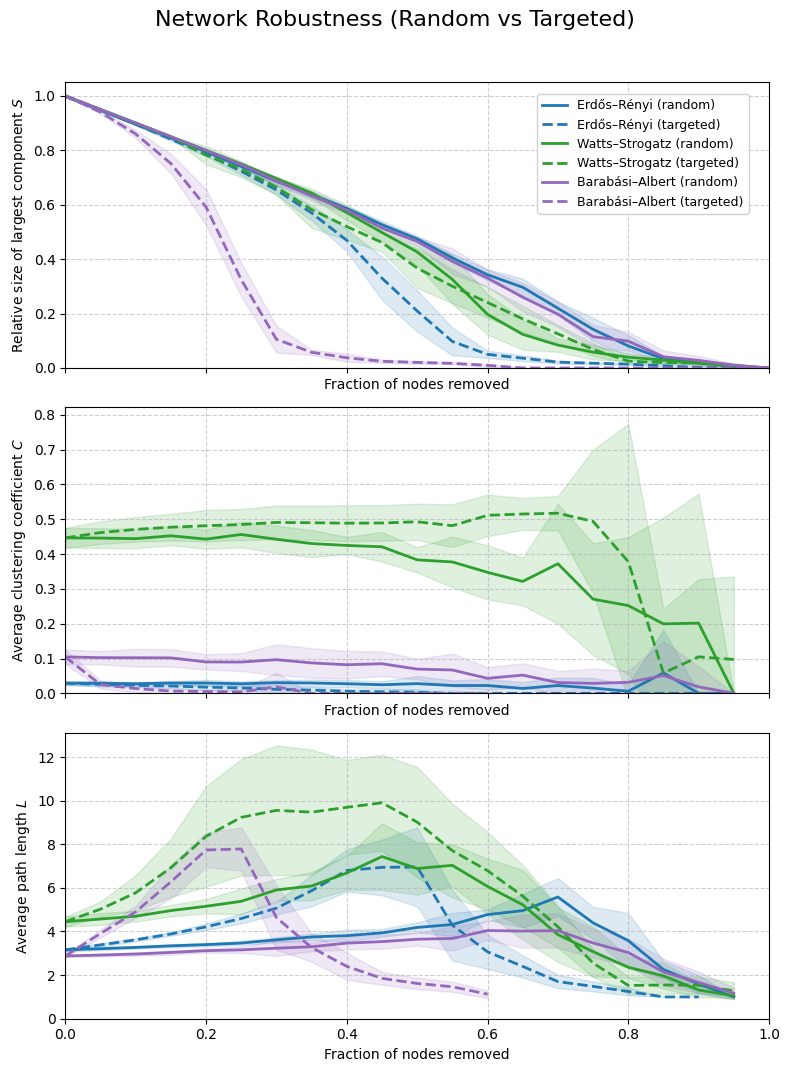

In [59]:
# -----------------------------
# Plot 1–3: Mean structural metric
# -----------------------------

fig, axs = plt.subplots(3, 1, figsize=(8, 11), sharex=True)

metrics_labels = [
    ("S_mean", "Relative size of largest component $S$"),
    ("C_mean", "Average clustering coefficient $C$"),
    ("L_mean", "Average path length $L$")
]

colors = {
    "Erdős–Rényi": "#1f77b4",
    "Watts–Strogatz": "#2ca02c",
    "Barabási–Albert": "#9467bd"
}

for ax, (metric, label) in zip(axs, metrics_labels):
    for model in df["model"].unique():
        color = colors[model]
        for strategy, ls, alpha in zip(["random", "targeted"], ["-", "--"], [0.8, 0.8]):
            subset = summary[(summary.model == model) & (summary.strategy == strategy)]
            std_subset = subset
            ax.plot(subset["fraction_removed"], subset[metric],
                    ls=ls, lw=2, color=color,
                    label=f"{model} ({strategy})")
            ax.fill_between(subset["fraction_removed"],
                            subset[metric] - std_subset[f"{metric[0]}_std"],
                            subset[metric] + std_subset[f"{metric[0]}_std"],
                            alpha=0.15, color=color)
    ax.set_xlabel("Fraction of nodes removed")
    ax.set_ylabel(label)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xlim(0, 1)
    ax.set_ylim(bottom=0)

# --- Overlay legend in the first panel ---
axs[0].legend(
    loc="upper right",
    frameon=True,
    framealpha=0.9,
    fontsize=9,
    ncol=1,
    bbox_to_anchor=(0.98, 0.98)
)

fig.suptitle("Network Robustness (Random vs Targeted)", fontsize=16, y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Step 6: Variability Across Trials

We use a **violin plot** to visualize variability in \( S \)
(the size of the largest connected component)
after removing 50% of nodes.

This illustrates stochastic variation:
- Random removal yields more spread.
- Targeted removal is consistently catastrophic for scale-free networks.

The violin shape encodes both distribution and density of outcomes across trials.

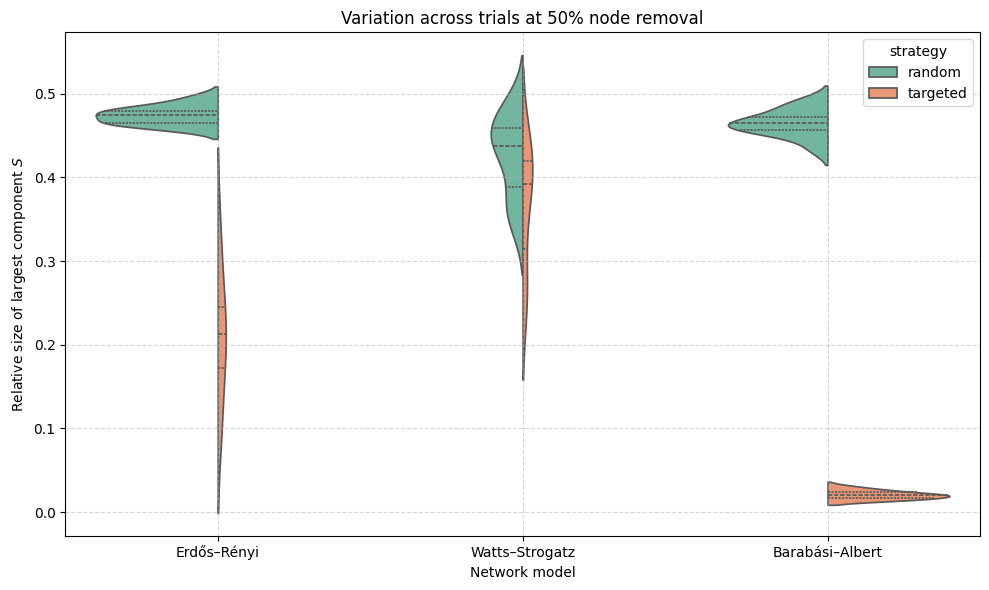

In [52]:
# -----------------------------
# Plot 4: Variability across trials (violin plot)
# -----------------------------
plt.figure(figsize=(10, 6))
subset = df[(df["fraction_removed"] == 0.5)]  # mid-removal snapshot
sns.violinplot(
    data=subset, x="model", y="S",
    hue="strategy", split=True, inner="quartile", palette="Set2"
)
plt.title("Variation across trials at 50% node removal")
plt.ylabel("Relative size of largest component $S$")
plt.xlabel("Network model")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Step 7: Discussion and Interpretation

**Key findings:**
- Real-world networks are not equally robust.
- Structure dictates resilience.

| Network Type | Random Failures | Targeted Attacks |
|---------------|-----------------|------------------|
| Erdős–Rényi | Moderate decline | Moderate decline |
| Watts–Strogatz | Gradual loss, high clustering persists | Similar to random |
| Barabási–Albert | Highly robust | Extremely fragile (hub removal) |

**Policy relevance:**
- Identify and protect critical hubs (airports, power substations, servers).
- Add redundancy to networks with strong hub dependence.
- Quantify trade-offs between efficiency and resilience.

This experiment illustrates how network theory directly informs system design and risk assessment.

## Step 8: Robustness–Efficiency Trade-off

In this final section, we connect our simulation-based results to a 
higher-level conceptual framework that compares **efficiency** and **robustness**
across different network topologies.

### 🔹 Background

Real-world networks must balance two competing design goals:

| Property | Description | Effect |
|-----------|--------------|--------|
| **Efficiency** | How easily information or flow travels through the network | High efficiency = short average paths |
| **Robustness** | How well the network remains connected under failure or attack | High robustness = network remains functional |

Different network models occupy distinct regions in this trade-off space:

- **Erdős–Rényi (Random):** moderate robustness and efficiency  
- **Watts–Strogatz (Small-world):** highly clustered and relatively robust  
- **Barabási–Albert (Scale-free):** extremely efficient but fragile under targeted attacks  

### 🔹 Quantifying the Trade-off

Using our previous simulation results, we define:

- **Robustness** — mean relative size of the largest connected component \( S \)  
  averaged across random node removals.  
- **Efficiency** — inverse of the average shortest path length \( L \)  
  in the original (undamaged) network.

Both measures are normalized to [0, 1] to allow comparison.

### 🔹 Visualization

The following plot shows each network type in the 
**Robustness–Efficiency space**, highlighting the structural trade-offs inherent in their design.

It provides a direct visual analogue to our policy discussion:
> *Highly efficient systems (like scale-free networks) can be fragile, while robust networks often sacrifice efficiency.*

,model,strategy,efficiency,robustness
0,Barabási–Albert,random,0.347499,0.464286
1,Barabási–Albert,targeted,0.347499,0.217135
2,Erdős–Rényi,random,0.316624,0.475481
3,Erdős–Rényi,targeted,0.316624,0.384577
4,Watts–Strogatz,random,0.224831,0.448630
5,Watts–Strogatz,targeted,0.224831,0.416667


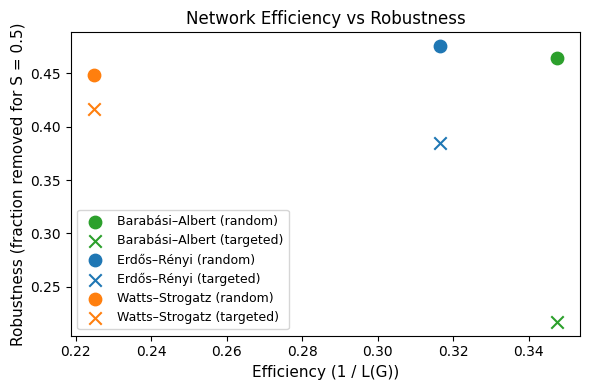

In [53]:
# --- Compute Efficiency and Robustness (S=0.5) ---

def find_fraction_for_S(df_model, target=0.5):
    """Find the fraction_removed where S_mean drops to target."""
    x = df_model["fraction_removed"].values
    y = df_model["S_mean"].values
    if np.all(y > target):
        return 1.0
    idx = np.where(y <= target)[0]
    if len(idx) == 0:
        return 1.0
    i = idx[0]
    if i == 0:
        return x[0]
    # Linear interpolation between points (i-1, i)
    x0, x1 = x[i-1], x[i]
    y0, y1 = y[i-1], y[i]
    return x0 + (target - y0) * (x1 - x0) / (y1 - y0)

eff_robust = []

for model in summary["model"].unique():
    # Efficiency: use L_mean at fraction_removed == 0
    L0 = summary[(summary["model"] == model) &
                 (summary["fraction_removed"] == 0)]["L_mean"].mean()
    efficiency = 1 / L0

    for strategy in ["random", "targeted"]:
        df_m = summary[(summary["model"] == model) & (summary["strategy"] == strategy)]
        robustness = find_fraction_for_S(df_m, target=0.5)
        eff_robust.append({
            "model": model,
            "strategy": strategy,
            "efficiency": efficiency,
            "robustness": robustness
        })

df_eff = pd.DataFrame(eff_robust)
display(df_eff)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6,4))
palette = {"Erdős–Rényi": "C0", "Watts–Strogatz": "C1", "Barabási–Albert": "C2"}

for _, row in df_eff.iterrows():
    color = palette[row["model"]]
    marker = 'o' if row["strategy"] == "random" else 'x'
    label = f'{row["model"]} ({row["strategy"]})'
    ax.scatter(row["efficiency"], row["robustness"], color=color, marker=marker, s=80, label=label)

ax.set_xlabel("Efficiency (1 / L(G))", fontsize=11)
ax.set_ylabel("Robustness (fraction removed for S = 0.5)", fontsize=11)
ax.set_title("Network Efficiency vs Robustness", fontsize=12)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()